In [1]:
# import required libraries
  
import librosa                     # librosa music package
import IPython                     # for playing audio
import numpy as np                 # for handling large arrays
import pandas as pd                # for data manipulation and analysis
import scipy                       # for common math functions
import os                          # for accessing local files

import librosa.display             # librosa plot functions
import matplotlib.pyplot as plt    # plotting with Matlab functionality
import seaborn as sns              # data visualization based on matplotlib
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# declare constants

# audio loading
SAMPLE_RATE = 16000
FRAME_LENGTH = 512
HOP_LENGTH = 256
N_FFT = 2048

# file paths
ROOT_CSV_PATH = 'data/virufy_cdf_coughvid.csv'
ROOT_DIR_PATH = 'data/wav/'
ROOT_DIR_PATH_PROCESSED = 'data/wav_processed/'

# Data Cleaning

In [3]:
# load coughvid dataset
coughvid_df_raw = pd.read_csv(ROOT_CSV_PATH)

# filter cough with 0.7 threshold - this means audio is 70% likely to be a cough
mask = (coughvid_df_raw.loc[:,'cough_detected'] > 0.7)
coughvid_df_cough = coughvid_df_raw.loc[mask,:]

# filter out untested results from clinically inferred PCR test results
mask = (coughvid_df_cough.loc[:,'pcr_test_result_inferred'] == 'untested')
coughvid_df = coughvid_df_cough.loc[~mask,:]

coughvid_df.sample(5)

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
3214,3214,coughvid,a74f89bf-12f2-486b-99e2-0d21c37f8b89,0.9493,data/wav/a74f89bf-12f2-486b-99e2-0d21c37f8b89.wav,31.0,male,male,2020-04-11T22:03:16.375490+00:00,NaN,NaN,False,False,untested,negative,False
18920,18920,coughvid,5d2d401f-743f-40a2-896c-af7e63c8de19,0.8710,data/wav/5d2d401f-743f-40a2-896c-af7e63c8de19.wav,NaN,female,female,2020-04-13T14:57:26.374768+00:00,NaN,NaN,False,False,untested,negative,False
20009,20009,coughvid,7fd45862-0c42-4a25-8b5e-9ecef18b6640,0.9560,data/wav/7fd45862-0c42-4a25-8b5e-9ecef18b6640.wav,27.0,male,male,2020-11-13T10:35:48.338336+00:00,NaN,NaN,False,False,untested,negative,False
5444,5444,coughvid,356cafc9-898d-46cc-ba26-6ccd0a78c1ad,0.9219,data/wav/356cafc9-898d-46cc-ba26-6ccd0a78c1ad.wav,43.0,female,female,2020-04-15T02:22:33.215835+00:00,NaN,NaN,False,False,untested,negative,False
481,481,coughvid,2687c6bd-f9cc-43a3-b7f3-d0663cc77e65,1.0000,data/wav/2687c6bd-f9cc-43a3-b7f3-d0663cc77e65.wav,50.0,male,male,2020-04-13T18:46:50.076336+00:00,NaN,NaN,True,False,untested,negative,False


# Exploratory Data Analysis on Original Dataset

In [4]:
coughvid_df_paths = coughvid_df['cough_path']

cough_filenames = coughvid_df_paths.values.tolist()

cough_filenames[:20]

['data/wav/68d5215b-afdb-4b7a-81d3-fbd5677de7b4.wav',
 'data/wav/3449851d-799e-404e-b143-58e852332948.wav',
 'data/wav/0c35e382-31cd-42cb-bc87-8a84b9c52a41.wav',
 'data/wav/cdd18865-400a-448e-902b-c8b53644a1c8.wav',
 'data/wav/0e35f667-974e-4ffc-b596-1b9a94793d1b.wav',
 'data/wav/52e79345-7280-4d22-9586-6214f5e3b95f.wav',
 'data/wav/d94d9646-3aa9-4ee7-9924-3c901fecf103.wav',
 'data/wav/4d59fd9a-236d-45ea-8b4d-bb9fe9857f8a.wav',
 'data/wav/73cbea4e-1884-4294-ba75-e2de6a8db118.wav',
 'data/wav/f8e542cd-28a5-484d-98aa-7249469ce78a.wav',
 'data/wav/069e6694-eadb-4864-82fe-532c07d22bc6.wav',
 'data/wav/95506d1a-d88f-4e15-87ad-f67ffb5471d5.wav',
 'data/wav/bab03040-f63f-410c-a3d4-8b2bf194fa50.wav',
 'data/wav/5e5ed149-7ce2-42dd-a599-6747f66c3d84.wav',
 'data/wav/1227b27b-6873-475d-8d44-3b7853245330.wav',
 'data/wav/87bdaf4c-d5db-4c92-a606-7c0b0eacb8c0.wav',
 'data/wav/e6ba12b4-ffd4-4dab-9f5c-e0c5d042c5d3.wav',
 'data/wav/ef481aa4-a9e4-490f-a47c-a0345613daf9.wav',
 'data/wav/e5903306-55ab-4d3

In [ ]:
from tqdm.notebook import tqdm
import math

def generate_waveforms(sample_filenames):
    '''
    This is a helper function that plots waveform graphs (amplitude across time) of each sample.
    
    Parameters:
        sample_filenames: Array of original sample filenames
    '''
    
    ncols = 5
    nrows = math.ceil(len(sample_filenames)/ncols)
    fig_height = 2.5*nrows

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(15, fig_height))

    for i, filename in enumerate(tqdm(sample_filenames, desc='Generating waveforms')):

        # [0] because sample is loaded as a tuple
        sample = librosa.load(filename, SAMPLE_RATE, mono=True)[0]

        # remove file path and filetype
        sample_name_split = filename.split('/')[-1].split('.')[0]
        sample_name = 'Sample ' + sample_name_split.split('-')[0]
        
        cur_col = math.floor(i/ncols)
        cur_row = i%(ncols)

        # generate waveplots
        librosa.display.waveplot(sample, sr=SAMPLE_RATE, ax=axs[cur_col, cur_row], color='b')
        axs[cur_col, cur_row].title.set_text(sample_name)

    plt.tight_layout()

In [ ]:
generate_waveforms(cough_filenames[:20])

In [ ]:
def display_spectrogram(filename):

    # [0] because sample is loaded as a tuple
    sample = librosa.load(filename, SAMPLE_RATE)[0]
    
    # remove file path and filetype
    sample_name_split = filename.split('/')[-1].split('.')[0]
    sample_name = 'Sample ' + sample_name_split.split('-')[0]

    # calculate the short-time Fourier transform
    x = librosa.stft(sample, n_fft=N_FFT, hop_length=HOP_LENGTH)
    sample = librosa.amplitude_to_db(abs(x))
    
    # geenrate spectrogram from STFT
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(sample, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, 
                         x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(sample_name)

In [ ]:
display_spectrogram(cough_filenames[0])

# Segmentation Algorithm Parameter Tuning

In [117]:
import cough_segmentation_tool as cst

cough_segmenter = cst.CoughSegmentationTool()
cough_segmenter_debug = cst.CoughSegmentationTool(debug=True)

In [ ]:
cough_segmenter.run_rmse_normalization_diagnostics(cough_filenames[:4])

In [ ]:
cough_segmenter_debug.run_onset_offset_detection_diagnostics(cough_filenames[:1])

In [ ]:
cough_segmenter.run_onset_offset_detection_diagnostics(cough_filenames[:40], threshold=0.6, minimum_distance=30, trim_frames=True)

# Isolated Cough Sample Exportation with Segmentation Algorithm

In [125]:
# cough_segmenter = cst.CoughSegmentationTool(threshold=0.6, minimum_distance=30, trim_frames=True)
# cough_segmenter.run_segmentation(cough_filenames, ROOT_DIR_PATH_PROCESSED)

cough_segmenter = cst.CoughSegmentationTool(threshold=0.6, minimum_distance=30, trim_frames=True)
cough_segmenter.run_segmentation(cough_filenames, ROOT_DIR_PATH_PROCESSED)

Processing samples:   0%|          | 0/7766 [00:00<?, ?it/s]

2022-01-18 14:37:45,145 - ERROR - 3449851d had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:49,359 - ERROR - e6ba12b4 had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:53,848 - ERROR - daa38f5c had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:55,469 - ERROR - 04284e37 had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:55,808 - ERROR - 43e0e749 had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:57,210 - ERROR - 62d2ee16 had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:57,788 - ERROR - 024ba604 had an error: "can't extend empty axis 0 using modes other than 'constant' or 'empty'". Skipped.
2022-01-18 14:37:58,

In [5]:
isolated_cough_filenames = list()
for filename in os.listdir(ROOT_DIR_PATH_PROCESSED):
    isolated_cough_filenames.append(ROOT_DIR_PATH_PROCESSED + filename)

isolated_cough_filenames = np.array(isolated_cough_filenames)

len(isolated_cough_filenames)

20274

# Exploratory Data Analysis on Isolated Cough Dataset

In [ ]:
generate_waveforms(isolated_cough_filenames[:20])

In [150]:
import itertools

def get_isolated_cough_distribution_plots(isolated_cough_filenames, title=None):
    '''
    This is a helper function that plots two distribution plots for two summary statistics
    number of isolated coughs and duration of isolated coughs for the specified isolated cough dataset.
    Parameters:
        isolated_cough_filenames: Array of isolated cough sample filenames
        title: Title of plot
    '''
    
    isolated_cough_durations = list()
    for filename in isolated_cough_filenames:
        
        # [0] because sample is loaded as a tuple
        sample = librosa.load(filename, SAMPLE_RATE, mono=True)[0]
        
        # get the duration of the sample in seconds
        cough_duration = librosa.get_duration(sample, sr=SAMPLE_RATE)
        isolated_cough_durations.append(cough_duration)
    
    # sum the number of isolated coughs for every original cough sample
    l = [(x.split('/')[-1].rsplit('_')[0], x.rsplit('_')[-1][:-4]) for x in isolated_cough_filenames]
    number_isolated_coughs = []
    for k, g in itertools.groupby(l, key=lambda x: x[0]):
        number_isolated_coughs.append(tuple([k, len(list(g))]))

    # create dataframe 
    isolated_coughs_dict = dict((x, y) for x, y in number_isolated_coughs)
    isolated_coughs_df = pd.DataFrame(isolated_coughs_dict.items(), columns=['ID', 'num_cough'])
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

    # plot bar graph of number of coughs distribution
    ax1.bar(x=isolated_coughs_df.ID, height=isolated_coughs_df.num_cough, align='edge', width=1.0, color='#7289DA')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set(xlabel='Original Samples', ylabel='Number of Isolated Coughs', title='Number of Isolated Coughs')
    
    # plot histogram of cough durations distribution
    sns.histplot(isolated_cough_durations, kde=True, color='b', ax=ax2)
    ax2.set(xlabel='Duration of Isolated Coughs', title='Duration of Isolated Coughs')
    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout()

In [70]:
import itertools

def get_isolated_cough_distribution_plots_2(isolated_cough_filenames, title=None):
    '''
    This is a helper function that plots two distribution plots for two summary statistics
    number of isolated coughs and duration of isolated coughs for the specified isolated cough dataset.
    Parameters:
        isolated_cough_filenames: Array of isolated cough sample filenames
        title: Title of plot
    '''
    
    isolated_cough_durations = list()
    for filename in isolated_cough_filenames:
        
        # [0] because sample is loaded as a tuple
        sample = librosa.load(filename, SAMPLE_RATE, mono=True)[0]
        
        # get the duration of the sample in seconds
        cough_duration = librosa.get_duration(sample, sr=SAMPLE_RATE)
        isolated_cough_durations.append(cough_duration)
    
    # sum the number of isolated coughs for every original cough sample
    l = [(x.split('/')[-1].rsplit('_')[0], x.rsplit('_')[-1][:-4]) for x in isolated_cough_filenames]
    number_isolated_coughs = []
    for k, g in itertools.groupby(l, key=lambda x: x[0]):
        number_isolated_coughs.append(tuple([k, len(list(g))]))
    
    # split list into thirds - we do this to allow three bar graphs to be plot
    # as there are so may samples that data is lost in a single graph
    new_list = [number_isolated_coughs[i * len(number_isolated_coughs) // 3: 
        (i + 1) * len(number_isolated_coughs) // 3] for i in range(3)]
    isolated_coughs_1 = new_list[0]
    isolated_coughs_2 = new_list[1]
    isolated_coughs_3 = new_list[2]

    # create three dictionaries from isolated cough lists
    isolated_coughs_dict_1 = dict((x, y) for x, y in isolated_coughs_1)
    isolated_coughs_dict_2 = dict((x, y) for x, y in isolated_coughs_2)
    isolated_coughs_dict_3 = dict((x, y) for x, y in isolated_coughs_3)

    # create three dataframes from isolated cough dictionaries
    isolated_coughs_df_1 = pd.DataFrame(isolated_coughs_dict_1.items(), columns=['ID', 'num_cough'])
    isolated_coughs_df_2 = pd.DataFrame(isolated_coughs_dict_2.items(), columns=['ID', 'num_cough'])
    isolated_coughs_df_3 = pd.DataFrame(isolated_coughs_dict_3.items(), columns=['ID', 'num_cough'])

    # plot three bar graphs of number of coughs distribution
    # plot single histogram of cough durations distribution

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    
    ax[0, 0].bar(x=isolated_coughs_df_1.ID, height=isolated_coughs_df_1.num_cough, align='edge', width=1.0, color='#7289DA')
    plt.setp(ax[0, 0].get_xticklabels(), rotation=45, ha='right')
    ax[0, 0].set_xticklabels([])
    ax[0, 0].set_xticks([])
    ax[0, 0].set(xlabel='1/3 Original Samples', ylabel='Number of Isolated Coughs', title='Number of Isolated Coughs')

    ax[0, 1].bar(x=isolated_coughs_df_2.ID, height=isolated_coughs_df_2.num_cough, align='edge', width=1.0, color='#7289DA')
    plt.setp(ax[0, 1].get_xticklabels(), rotation=45, ha='right')
    ax[0, 1].set_xticklabels([])
    ax[0, 1].set_xticks([])
    ax[0, 1].set(xlabel='2/3 Original Samples', ylabel='Number of Isolated Coughs', title='Number of Isolated Coughs')

    ax[1, 0].bar(x=isolated_coughs_df_3.ID, height=isolated_coughs_df_3.num_cough, align='edge', width=1.0, color='#7289DA')
    plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha='right')
    ax[1, 0].set_xticklabels([])
    ax[1, 0].set_xticks([])
    ax[1, 0].set(xlabel='3/3 Original Samples', ylabel='Number of Isolated Coughs', title='Number of Isolated Coughs')

    sns.histplot(isolated_cough_durations, kde=True, color='b', ax=ax[1, 1])
    ax[1, 1].set(xlabel='Duration of Isolated Coughs', title='Duration of Isolated Coughs')

    fig.suptitle(title, y=1, fontsize=16)
    fig.tight_layout()

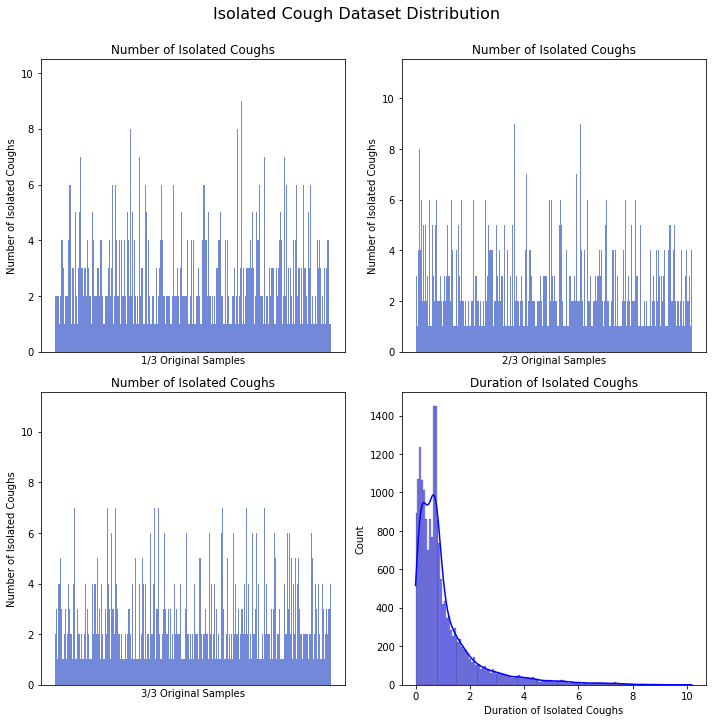

In [71]:
get_isolated_cough_distribution_plots_2(isolated_cough_filenames, 'Isolated Cough Dataset Distribution')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='y', frac_train=0.8, 
                                         frac_val=0.1, frac_test=0.1, random_state=None):
    '''
    Splits a dataframe into three subsets (train, validation, and test) following fractional 
    ratios provided by the user, where each subset is stratified by the values in a specific 
    column (that is, each subset has the same relative frequency of the values in the column). 
    It performs this splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(f'Fractions {frac_train}, {frac_val}, {frac_test} do not add up to 1.')

    if stratify_colname not in df_input.columns:
        raise ValueError(f'{stratify_colname} is not a column in the dataframe.')
    
    # dataframe containing all columns
    X = df_input
    # dataframe of just column on which to stratify
    y = df_input[[stratify_colname]]

    # split original dataframe into train and temp dataframes
    df_train, df_temp, y_train, y_temp = train_test_split(X, y, stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # split the temp dataframe into val and test dataframes
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

In [ ]:
# splitting into 70% training, 15% validation, 15% testing sets
original_train_df, original_val_df, original_test_df = \
    split_stratified_into_train_val_test(coughvid_df, stratify_colname='pcr_test_result_inferred', 
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [ ]:
original_train_df.shape, original_val_df.shape, original_test_df.shape